Import Important Libraries

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from datetime import datetime as dt
print('Libraries Imported')

Libraries Imported


We import .csv datafile generated by collect_data.ipynb, we have excluded texts from x ,texts are first processed and then combined with x

In [62]:
dataset = pd.read_csv('News.csv')
x = dataset.iloc[:,[0,3,5,6,7]].values #no text column included
y = dataset.iloc[:,-1].values
print(dataset.head(3))
print('\n---->Dataset Loaded')

   channel                 id  \
0  bbcnews  10157728122492217   
1  bbcnews  10157728074267217   
2  bbcnews  10157727901822217   

                                                 url  timespan  \
0  https://m.facebook.com/story.php?story_fbid=10...  1.891389   
1  https://m.facebook.com/story.php?story_fbid=10...  2.320278   
2  https://m.facebook.com/story.php?story_fbid=10...  3.813333   

                                                text  image   likes  comments  \
0          Remembering 100 NHS workers who have died    1.0  2327.0     333.0   
1  Rising virus care home toll leads to record de...    1.0   950.0     197.0   
2      Top NYC coronavirus doctor takes her own life    1.0  5854.0    1533.0   

   shares  
0     544  
1     186  
2    3332  

---->Dataset Loaded


We perform processing of the column containing description <b>(content of the post)</b>.
We use the text and analyse it's mood to predict whether it would go on to become more viral(more shares) or not

In [63]:
text = dataset['text']
processed = processed.str.replace(r'£|\$', 'money ') #replace money symbol by 'money'
processed = processed.str.replace(r'\d+(\.\d+)?', 'number ') #replace a numerical value by word 'number'
processed = processed.str.replace(r'[^\w\d\s]', ' ')
processed = processed.str.lower() #convert text to lowercase
processed = processed.str.replace(r'^b\s+', '')
processed = processed.str.replace(r'\s+', ' ')
processed = processed.str.replace(r'^\s+|\s+?$', '')
processed = processed.str.replace(r'\s+[a-zA-Z]\s+', ' ') #remove single letters
processed = processed.str.replace(r'\^[a-zA-Z]\s+', ' ') #remove special symbols
print('Text Cleaning Complete\n')
print(processed[:10])

Text Cleaning Complete

0                          rememb number nh worker die
1           rise viru care home toll lead record death
2                  top nyc coronaviru doctor take life
3                          nz beat viru got coffe back
4               uk hold minut silenc fallen key worker
5                    trump imagin disinfect call spike
6    bereav frontlin famili entitl money number number
7      cuban doctor go south africa fight covid number
8                el salvador gang take advantag pandem
9                 notr dame repair start amid lockdown
Name: text, dtype: object


In Text analysis we perform stemming of words (done below), 
stemmming comverts words into their root form making it easier
 for our model to understand the co-relation between no of shares
 and mood of the text

In [64]:
stop_words = set(stopwords.words('english'))
processed = processed.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
ps = nltk.PorterStemmer()
processed = processed.apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))
print('Text Stemming Complete')
print(processed[:10])

Text Stemming Complete
0                          rememb number nh worker die
1           rise viru care home toll lead record death
2                  top nyc coronaviru doctor take life
3                           nz beat viru got coff back
4               uk hold minut silenc fallen key worker
5                    trump imagin disinfect call spike
6    bereav frontlin famili entitl money number number
7      cuban doctor go south africa fight covid number
8                el salvador gang take advantag pandem
9                 notr dame repair start amid lockdown
Name: text, dtype: object


<b>Vectorization</b> : Computers cant understand text directly, we vectorize texts into readable form (numbers) so that our model can understand them. vectorization gives a vector with numerical entries. <b>We create a vector of 1500 most common words to input to our model</b>.

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, stop_words = 'english')
text = vectorizer.fit_transform(processed).toarray()
print('vectorized text :' ,text[0])
print('Sparse Matrix :' ,text)

vectorized text : [0 0 0 ... 0 0 0]
Sparse Matrix : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<b> Encoding </b>: It is done to process categorical data (channel name in this case)

In [66]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()
x[:, 0] = labelencoder.fit_transform(x[:, 0])
# Converting to no-preference variable
onehotencoder = OneHotEncoder(categorical_features = [0])
x = onehotencoder.fit_transform(x).toarray()
# Avoiding the Dummy Variable Trap
x = x[:, 1:]

Now we Combine the vectorized data with data of x, this x will be our input variable to the model

In [67]:
combine = []
for i in range(len(x)) : 
    total = []
    
    for j in x[i] : 
        total.append(j)
    for j in text[i] : 
        total.append(j)
    
    # combining together features(time,likes,shared etc) from dataset and vectorized text 
    combine.append(total)

x = np.array(combine)
print('Input Data : ',x[0])

Input Data :  [0. 0. 0. ... 0. 0. 0.]


We define accruacy parameter as fraction, 
f = predicted values within an error of 15% of actual values / total number of actual values ,
value of error percentage mu can be changed as per needed

In [89]:
# 15% error is tolerable
mu = 0.15 
def accuracy(actual,predicted) : 
    count = 0
    for i in range(len(actual)) : 
        if abs(actual[i]-predicted[i]) <= mu*actual[i] : 
            count = count+1
            
    return count/len(actual)

<b> Splitting data into train and test sets </b> : we keep test size at 20 % of train size

In [111]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3)
print('Dimensions of input train and test data :',x_train.shape,x_test.shape)
print('Dimensions of output train and test data :',y_train.shape,y_test.shape)
print(y_train.shape[0],' TRAINING samples \n',
      y_test.shape[0],' TESTING samples.')

Dimensions of input train and test data : (5442, 1516) (1361, 1516)
Dimensions of output train and test data : (5442,) (1361,)
5442  TRAINING samples 
 1361  TESTING samples.


Perform Prediction using ML models and evaluate the accuracy metrics

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

reg = ['Linear Regressor','SVR-rbf','SVR-sigmoid','RF-10','RF-100']
regressor_list = [LinearRegression(),
                  SVR(kernel = 'rbf'),
                  SVR(kernel = 'sigmoid'),
             RandomForestRegressor(n_estimators = 10, random_state = 0),
             RandomForestRegressor(n_estimators = 100, random_state = 0)]

print('Regressors Loading...')
for regressor in reg : 
    print(regressor,' loaded')

Regressors Loading...
Linear Regressor  loaded
SVR-rbf  loaded
SVR-sigmoid  loaded
RF-10  loaded
RF-100  loaded


<b> Train and Predict </b>

In [74]:
now = dt.now()
for regressor,name in zip(regressor_list,reg) : 
    regressor.fit(x_train,y_train)
    score = accuracy(y_test,regressor.predict(x_test))
    print(name,'-',round(score*100,2),' %')
    
now = dt.now()-now

Linear Regressor - 6.45  %
SVR-rbf - 13.78  %
SVR-sigmoid - 3.23  %
RF-10 - 22.87  %
RF-100 - 25.22  %


In [77]:
print('Time taken to train ML models : ',round((now.seconds/60),2),' minutes')

Time taken to train ML models :  8.77  minutes


<b>Obseravtions </b> : Various ML models <b>fail to understand the pattern</b> in our data as they perfrom with very low accuracy ,therefore we deploy <b>Deep Neural Networks</b> to analyse our Model.

In [78]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

print('Imported Neural Network Frameworks')

Imported Neural Network Frameworks


<b>Network Architechture </b> : our DNN model has input dense layer, 3 hidden layers with 128 nodes and output layer

In [81]:
def NeuralNetwork(size) : 
    model = Sequential()

    # The Input Layer :
    model.add(Dense(64, kernel_initializer='normal',input_dim = size, activation='relu'))

    # The Hidden Layers :
    model.add(Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(Dense(128, kernel_initializer='normal',activation='relu'))


    # The Output Layer :
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

print('Model Architecture Created\n')
size = x.shape[1]
model = NeuralNetwork(size)
model.summary()

Model Architecture Created

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                97088     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 138,561
Trainable params: 138,561
Non-trainable params: 0
_________________________________________________________________


<b> Training The DNN Model </b>

In [82]:
now = dt.now()
model.fit(x, y, epochs=500, batch_size=32, validation_split = 0.2)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
now = dt.now() - now

Train on 5442 samples, validate on 1361 samples
Epoch 1/500
5442/5442 [==============================] - 1s - loss: 318.0220 - mean_absolute_error: 318.0220 - val_loss: 157.3181 - val_mean_absolute_error: 157.3181
Epoch 2/500
5442/5442 [==============================] - 1s - loss: 257.5369 - mean_absolute_error: 257.5369 - val_loss: 140.6194 - val_mean_absolute_error: 140.6194
Epoch 3/500
5442/5442 [==============================] - 1s - loss: 234.8323 - mean_absolute_error: 234.8323 - val_loss: 127.0439 - val_mean_absolute_error: 127.0439
Epoch 4/500
5442/5442 [==============================] - 1s - loss: 233.6269 - mean_absolute_error: 233.6269 - val_loss: 145.3715 - val_mean_absolute_error: 145.3715
Epoch 5/500
5442/5442 [==============================] - 1s - loss: 223.9370 - mean_absolute_error: 223.9370 - val_loss: 139.6529 - val_mean_absolute_error: 139.6529
Epoch 6/500
5442/5442 [==============================] - 1s - loss: 214.4809 - mean_absolute_error: 214.4809 - val_loss: 1

5442/5442 [==============================] - 1s - loss: 137.3654 - mean_absolute_error: 137.3654 - val_loss: 95.6491 - val_mean_absolute_error: 95.6491
Epoch 50/500
5442/5442 [==============================] - 1s - loss: 144.1803 - mean_absolute_error: 144.1803 - val_loss: 99.1366 - val_mean_absolute_error: 99.1366
Epoch 51/500
5442/5442 [==============================] - 1s - loss: 144.3151 - mean_absolute_error: 144.3151 - val_loss: 83.4785 - val_mean_absolute_error: 83.4785
Epoch 52/500
5442/5442 [==============================] - 1s - loss: 150.2873 - mean_absolute_error: 150.2873 - val_loss: 101.1678 - val_mean_absolute_error: 101.1678
Epoch 53/500
5442/5442 [==============================] - 1s - loss: 141.9361 - mean_absolute_error: 141.9361 - val_loss: 83.9354 - val_mean_absolute_error: 83.9354
Epoch 54/500
5442/5442 [==============================] - 1s - loss: 139.2491 - mean_absolute_error: 139.2491 - val_loss: 95.9296 - val_mean_absolute_error: 95.9296
Epoch 55/500
5442/544

5442/5442 [==============================] - 1s - loss: 111.7079 - mean_absolute_error: 111.7079 - val_loss: 74.9297 - val_mean_absolute_error: 74.9297
Epoch 99/500
5442/5442 [==============================] - 1s - loss: 113.1659 - mean_absolute_error: 113.1659 - val_loss: 114.9175 - val_mean_absolute_error: 114.9175
Epoch 100/500
5442/5442 [==============================] - 1s - loss: 114.7191 - mean_absolute_error: 114.7191 - val_loss: 68.6722 - val_mean_absolute_error: 68.6722
Epoch 101/500
5442/5442 [==============================] - 1s - loss: 129.9689 - mean_absolute_error: 129.9689 - val_loss: 80.7022 - val_mean_absolute_error: 80.7022
Epoch 102/500
5442/5442 [==============================] - 1s - loss: 103.7870 - mean_absolute_error: 103.7870 - val_loss: 81.2583 - val_mean_absolute_error: 81.2583
Epoch 103/500
5442/5442 [==============================] - 1s - loss: 112.9130 - mean_absolute_error: 112.9130 - val_loss: 83.6063 - val_mean_absolute_error: 83.6063
Epoch 104/500
544

5442/5442 [==============================] - 0s - loss: 84.4649 - mean_absolute_error: 84.4649 - val_loss: 64.8076 - val_mean_absolute_error: 64.8076
Epoch 148/500
5442/5442 [==============================] - 0s - loss: 91.0834 - mean_absolute_error: 91.0834 - val_loss: 75.1674 - val_mean_absolute_error: 75.1674
Epoch 149/500
5442/5442 [==============================] - 1s - loss: 123.1075 - mean_absolute_error: 123.1075 - val_loss: 62.0332 - val_mean_absolute_error: 62.0332
Epoch 150/500
5442/5442 [==============================] - 1s - loss: 85.0049 - mean_absolute_error: 85.0049 - val_loss: 62.4112 - val_mean_absolute_error: 62.4112
Epoch 151/500
5442/5442 [==============================] - 0s - loss: 92.0499 - mean_absolute_error: 92.0499 - val_loss: 161.1206 - val_mean_absolute_error: 161.1206
Epoch 152/500
5442/5442 [==============================] - 0s - loss: 118.5557 - mean_absolute_error: 118.5557 - val_loss: 79.3014 - val_mean_absolute_error: 79.3014
Epoch 153/500
5442/5442 

5442/5442 [==============================] - 1s - loss: 74.1596 - mean_absolute_error: 74.1596 - val_loss: 64.3579 - val_mean_absolute_error: 64.3579
Epoch 197/500
5442/5442 [==============================] - 1s - loss: 74.4770 - mean_absolute_error: 74.4770 - val_loss: 50.3407 - val_mean_absolute_error: 50.3407
Epoch 198/500
5442/5442 [==============================] - 1s - loss: 83.0220 - mean_absolute_error: 83.0220 - val_loss: 69.8555 - val_mean_absolute_error: 69.8555
Epoch 199/500
5442/5442 [==============================] - 1s - loss: 65.0135 - mean_absolute_error: 65.0135 - val_loss: 51.5267 - val_mean_absolute_error: 51.5267
Epoch 200/500
5442/5442 [==============================] - 1s - loss: 74.4822 - mean_absolute_error: 74.4822 - val_loss: 51.3897 - val_mean_absolute_error: 51.3897
Epoch 201/500
5442/5442 [==============================] - 1s - loss: 73.4907 - mean_absolute_error: 73.4907 - val_loss: 47.5665 - val_mean_absolute_error: 47.5665
Epoch 202/500
5442/5442 [=====

5442/5442 [==============================] - 1s - loss: 85.3453 - mean_absolute_error: 85.3453 - val_loss: 52.1603 - val_mean_absolute_error: 52.1603
Epoch 246/500
5442/5442 [==============================] - 1s - loss: 74.0667 - mean_absolute_error: 74.0667 - val_loss: 51.6254 - val_mean_absolute_error: 51.6254
Epoch 247/500
5442/5442 [==============================] - 1s - loss: 112.0601 - mean_absolute_error: 112.0601 - val_loss: 84.5151 - val_mean_absolute_error: 84.5151
Epoch 248/500
5442/5442 [==============================] - 1s - loss: 70.5644 - mean_absolute_error: 70.5644 - val_loss: 60.8734 - val_mean_absolute_error: 60.8734
Epoch 249/500
5442/5442 [==============================] - 1s - loss: 67.7093 - mean_absolute_error: 67.7093 - val_loss: 68.5129 - val_mean_absolute_error: 68.5129
Epoch 250/500
5442/5442 [==============================] - 1s - loss: 67.9290 - mean_absolute_error: 67.9290 - val_loss: 57.7797 - val_mean_absolute_error: 57.7797
Epoch 251/500
5442/5442 [===

5442/5442 [==============================] - 1s - loss: 60.4992 - mean_absolute_error: 60.4992 - val_loss: 43.5394 - val_mean_absolute_error: 43.5394
Epoch 296/500
5442/5442 [==============================] - 1s - loss: 45.6962 - mean_absolute_error: 45.6962 - val_loss: 54.5691 - val_mean_absolute_error: 54.5691
Epoch 297/500
5442/5442 [==============================] - 1s - loss: 49.0918 - mean_absolute_error: 49.0918 - val_loss: 47.5758 - val_mean_absolute_error: 47.5758
Epoch 298/500
5442/5442 [==============================] - 1s - loss: 55.8907 - mean_absolute_error: 55.8907 - val_loss: 70.2652 - val_mean_absolute_error: 70.2652
Epoch 299/500
5442/5442 [==============================] - 1s - loss: 53.9370 - mean_absolute_error: 53.9370 - val_loss: 52.4613 - val_mean_absolute_error: 52.4613
Epoch 300/500
5442/5442 [==============================] - 1s - loss: 67.4816 - mean_absolute_error: 67.4816 - val_loss: 46.2130 - val_mean_absolute_error: 46.2130
Epoch 301/500
5442/5442 [=====

5442/5442 [==============================] - ETA: 0s - loss: 65.0485 - mean_absolute_error: 65.048 - 0s - loss: 64.5823 - mean_absolute_error: 64.5823 - val_loss: 43.0019 - val_mean_absolute_error: 43.0019
Epoch 346/500
5442/5442 [==============================] - 1s - loss: 38.0982 - mean_absolute_error: 38.0982 - val_loss: 55.7091 - val_mean_absolute_error: 55.7091
Epoch 347/500
5442/5442 [==============================] - 0s - loss: 58.0872 - mean_absolute_error: 58.0872 - val_loss: 64.8062 - val_mean_absolute_error: 64.8062
Epoch 348/500
5442/5442 [==============================] - 0s - loss: 51.6205 - mean_absolute_error: 51.6205 - val_loss: 43.0354 - val_mean_absolute_error: 43.0354
Epoch 349/500
5442/5442 [==============================] - 0s - loss: 70.9195 - mean_absolute_error: 70.9195 - val_loss: 41.8947 - val_mean_absolute_error: 41.8947
Epoch 350/500
5442/5442 [==============================] - 0s - loss: 54.2729 - mean_absolute_error: 54.2729 - val_loss: 49.2288 - val_mea

5442/5442 [==============================] - 0s - loss: 52.7882 - mean_absolute_error: 52.7882 - val_loss: 76.5914 - val_mean_absolute_error: 76.5914
Epoch 395/500
5442/5442 [==============================] - 0s - loss: 54.6794 - mean_absolute_error: 54.6794 - val_loss: 54.6908 - val_mean_absolute_error: 54.6908
Epoch 396/500
5442/5442 [==============================] - 0s - loss: 46.1612 - mean_absolute_error: 46.1612 - val_loss: 122.7549 - val_mean_absolute_error: 122.7549
Epoch 397/500
5442/5442 [==============================] - 1s - loss: 68.6903 - mean_absolute_error: 68.6903 - val_loss: 52.6393 - val_mean_absolute_error: 52.6393
Epoch 398/500
5442/5442 [==============================] - 1s - loss: 53.5157 - mean_absolute_error: 53.5157 - val_loss: 45.8343 - val_mean_absolute_error: 45.8343
Epoch 399/500
5442/5442 [==============================] - 0s - loss: 59.7398 - mean_absolute_error: 59.7398 - val_loss: 45.5844 - val_mean_absolute_error: 45.5844
Epoch 400/500
5442/5442 [===

5442/5442 [==============================] - 1s - loss: 43.2305 - mean_absolute_error: 43.2305 - val_loss: 81.4820 - val_mean_absolute_error: 81.4820
Epoch 445/500
5442/5442 [==============================] - 1s - loss: 44.7198 - mean_absolute_error: 44.7198 - val_loss: 51.1895 - val_mean_absolute_error: 51.1895
Epoch 446/500
5442/5442 [==============================] - 1s - loss: 40.3111 - mean_absolute_error: 40.3111 - val_loss: 45.0015 - val_mean_absolute_error: 45.0015
Epoch 447/500
5442/5442 [==============================] - 1s - loss: 52.1069 - mean_absolute_error: 52.1069 - val_loss: 49.4428 - val_mean_absolute_error: 49.4428
Epoch 448/500
5442/5442 [==============================] - 1s - loss: 49.4082 - mean_absolute_error: 49.4082 - val_loss: 78.1846 - val_mean_absolute_error: 78.1846
Epoch 449/500
5442/5442 [==============================] - 1s - loss: 45.9850 - mean_absolute_error: 45.9850 - val_loss: 38.6887 - val_mean_absolute_error: 38.6887
Epoch 450/500
5442/5442 [=====

5442/5442 [==============================] - 1s - loss: 38.4471 - mean_absolute_error: 38.4471 - val_loss: 65.6430 - val_mean_absolute_error: 65.6430
Epoch 495/500
5442/5442 [==============================] - 1s - loss: 55.0577 - mean_absolute_error: 55.0577 - val_loss: 42.7289 - val_mean_absolute_error: 42.7289
Epoch 496/500
5442/5442 [==============================] - 1s - loss: 36.3313 - mean_absolute_error: 36.3313 - val_loss: 76.7707 - val_mean_absolute_error: 76.7707
Epoch 497/500
5442/5442 [==============================] - 1s - loss: 48.5404 - mean_absolute_error: 48.5404 - val_loss: 46.8822 - val_mean_absolute_error: 46.8822
Epoch 498/500
5442/5442 [==============================] - 1s - loss: 48.3734 - mean_absolute_error: 48.3734 - val_loss: 49.0132 - val_mean_absolute_error: 49.0132
Epoch 499/500
5442/5442 [==============================] - 1s - loss: 43.2050 - mean_absolute_error: 43.2050 - val_loss: 57.0825 - val_mean_absolute_error: 57.0825
Epoch 500/500
5442/5442 [=====

In [85]:
print('Time taken to train DNN model : ',round(now.seconds/60,2),' minutes')

Time taken to train DNN model :  9.07  minutes


<b> Model Evaluation of Train and Test sets <b>

In [113]:
y_pred = model.predict(x_test)
print('accuracy on TRAIN data - ',round(accuracy(y_train,model.predict(x_train))*100,2),' %')
print('accuracy on TEST data - ',round(accuracy(y_test,y_pred)*100,2),' %')

model.save_weights('news_weights.hdf5')
model.save('news_virality.h5')
print('Model Saved')

accuracy on TRAIN data -  81.97  %
accuracy on TEST data -  80.6  %
Model Saved


<b> Conclusion </b> : an accuracy of 80% on test data, 4 in 5 predictions are close to the actual value (15% error), The model has performed with fairly good accuracy

<b>Data Visualisation </b> : We observe that predicted data very much overlaps with actual data denoting that our DNN model is <b>able to understand</b> the given data and make accurate conclusions

Visualising TRAIN data results


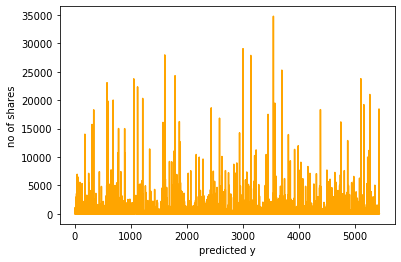

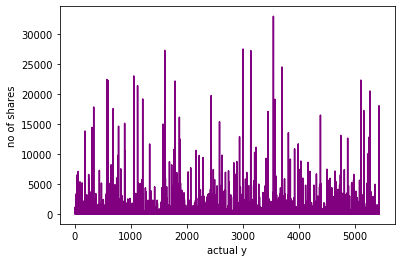

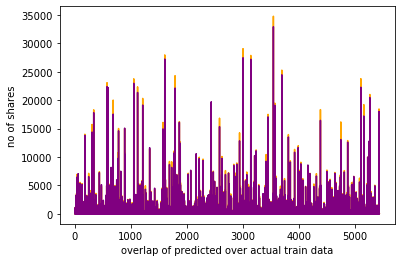

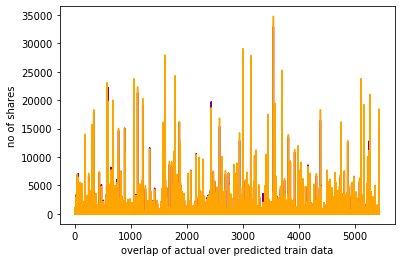

In [109]:
import matplotlib.pyplot as plt
print('Visualising TRAIN data results')

plt.plot(model.predict(x_train), color = 'orange')
plt.ylabel('no of shares')
plt.xlabel('predicted y')
plt.show()

plt.plot(y_train, color = 'purple')
plt.ylabel('no of shares')
plt.xlabel('actual y')
plt.show()

plt.plot(model.predict(x_train), color = 'orange')
plt.plot(y_train, color = 'purple')
plt.ylabel('no of shares')
plt.xlabel('overlap of predicted over actual train data')
plt.show()

plt.plot(y_train, color = 'purple')
plt.plot(model.predict(x_train), color = 'orange')

plt.ylabel('no of shares')
plt.xlabel('overlap of actual over predicted train data')
plt.show()

Visualising TEST data results


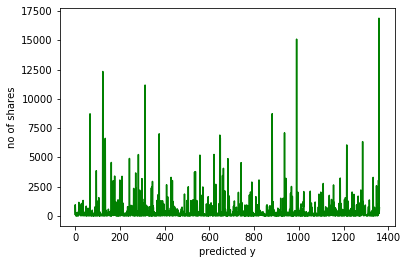

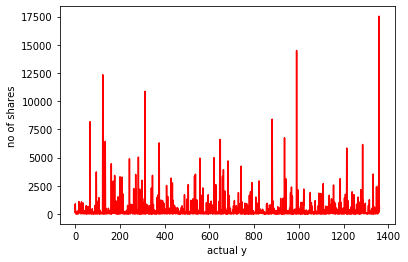

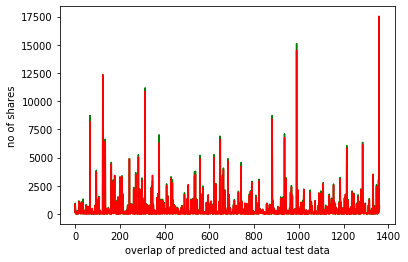

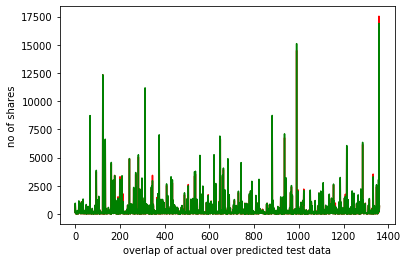

In [110]:
print('Visualising TEST data results')

plt.plot(y_pred, color = 'green')
plt.ylabel('no of shares')
plt.xlabel('predicted y')
plt.show()

plt.plot(y_test, color = 'red')
plt.ylabel('no of shares')
plt.xlabel('actual y')
plt.show()

plt.plot(y_pred, color = 'green')
plt.plot(y_test, color = 'red')
plt.ylabel('no of shares')
plt.xlabel('overlap of predicted and actual test data')
plt.show()

plt.plot(y_test, color = 'red')
plt.plot(y_pred, color = 'green')
plt.ylabel('no of shares')
plt.xlabel('overlap of actual over predicted test data')
plt.show()